Імпортуємо усі необхідні бібліотеки:

In [1]:
import pandas as pd
import numpy as np
from numpy import sqrt

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sb

from sqlalchemy.engine import URL
from sqlalchemy import create_engine

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from yellowbrick.regressor import PredictionError

Завантажимо усі дані з сховища даних у датафрейм:

In [2]:
connection_string = 'DRIVER={SQL Server};SERVER=LAPTOP-2T0TBBUP\SQLEXPRESS;DATABASE=MoviesDB;Trusted_Connection=yes'
connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": connection_string})
engine = create_engine(connection_url)
query = "SELECT * FROM moviesAnalysisWithAge"
movies = pd.read_sql(query, engine)

movies.info()
movies.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8276 entries, 0 to 8275
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               8276 non-null   int64  
 1   Name             8276 non-null   object 
 2   Genres           8276 non-null   object 
 3   RatingName       8276 non-null   object 
 4   Year             8276 non-null   int64  
 5   Month            7374 non-null   object 
 6   OscarWinSum      8276 non-null   int64  
 7   NominatedNumber  8276 non-null   int64  
 8   Gross            7383 non-null   float64
 9   Budget           7383 non-null   float64
 10  DurationMinutes  8263 non-null   float64
 11  VotesNumber      8200 non-null   float64
 12  ImbdScore        8248 non-null   float64
dtypes: float64(5), int64(4), object(4)
memory usage: 840.7+ KB


,id,Name,Genres,RatingName,Year,Month,OscarWinSum,NominatedNumber,Gross,Budget,DurationMinutes,VotesNumber,ImbdScore
0,1,#Saraitda,Action-Drama-Horror,TV-MA,2020,None,0,0,NaN,NaN,98.0,32671.0,6.3
1,2,(500) Days of Summer,Romance-Drama-Comedy,PG-13,2009,None,0,0,NaN,NaN,95.0,489549.0,7.7
2,3,*batteries not included,Comedy,PG,1987,December,0,0,65088797.0,25000000.0,106.0,32000000.0,6.7
3,4,[Rec],Thriller-Horror-Mystery,R,2007,None,0,0,NaN,NaN,78.0,172050.0,7.4
4,5,[Rec]²,Horror,R,2009,October,0,0,18853164.0,5600000.0,85.0,70000000.0,6.5


Оберемо стовпці, які буду факторами, а який буде відгуком. Ми хочемо прогнозувати прибутки фільму, тому оберемо прибуток як відгук, а інші стовпці будуть факторами:

In [3]:
factors = ['Year', 'OscarWinSum', 'NominatedNumber', 'Budget', 'DurationMinutes', 'VotesNumber', 'ImbdScore', 'Genres', 'RatingName']
response = 'Gross'

Проведемо обробку даних. Спочатку перевіримо, чи має дата фрейм пропущені значення:

In [4]:
movies.isnull().values.any()

True

Видалимо усі фільми, які не мають відгуку(касових зборів):

In [5]:
movies = movies.loc[movies['Gross'].notna() != 0]
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7383 entries, 2 to 8274
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               7383 non-null   int64  
 1   Name             7383 non-null   object 
 2   Genres           7383 non-null   object 
 3   RatingName       7383 non-null   object 
 4   Year             7383 non-null   int64  
 5   Month            7374 non-null   object 
 6   OscarWinSum      7383 non-null   int64  
 7   NominatedNumber  7383 non-null   int64  
 8   Gross            7383 non-null   float64
 9   Budget           7383 non-null   float64
 10  DurationMinutes  7383 non-null   float64
 11  VotesNumber      7339 non-null   float64
 12  ImbdScore        7383 non-null   float64
dtypes: float64(5), int64(4), object(4)
memory usage: 807.5+ KB


Заповнимо усі пропущені числові значення середніми:

In [6]:
numeric_columns = movies.select_dtypes(include=['number']).columns
means = movies[numeric_columns].mean()
movies[numeric_columns] = movies[numeric_columns].fillna(means)

movies.info()
movies.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7383 entries, 2 to 8274
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               7383 non-null   int64  
 1   Name             7383 non-null   object 
 2   Genres           7383 non-null   object 
 3   RatingName       7383 non-null   object 
 4   Year             7383 non-null   int64  
 5   Month            7374 non-null   object 
 6   OscarWinSum      7383 non-null   int64  
 7   NominatedNumber  7383 non-null   int64  
 8   Gross            7383 non-null   float64
 9   Budget           7383 non-null   float64
 10  DurationMinutes  7383 non-null   float64
 11  VotesNumber      7383 non-null   float64
 12  ImbdScore        7383 non-null   float64
dtypes: float64(5), int64(4), object(4)
memory usage: 807.5+ KB


,id,Name,Genres,RatingName,Year,Month,OscarWinSum,NominatedNumber,Gross,Budget,DurationMinutes,VotesNumber,ImbdScore
2,3,*batteries not included,Comedy,PG,1987,December,0,0,65088797.0,25000000.0,106.0,32000000.0,6.7
4,5,[Rec]²,Horror,R,2009,October,0,0,18853164.0,5600000.0,85.0,70000000.0,6.5
6,7,10 Cloverfield Lane,Action-Drama-Horror,PG-13,2016,March,0,0,110216998.0,15000000.0,103.0,306304.0,7.2
7,8,10 Things I Hate About You,Romance-Drama-Comedy,PG-13,1999,March,0,0,53478579.0,30000000.0,97.0,315247.0,7.3
8,9,10 to Midnight,Crime,R,1983,March,0,0,7175592.0,4520000.0,101.0,7200000.0,6.3


Видалимо усі фільми, які мають пропущені текстові значення:

In [7]:
movies.dropna(inplace=True)

movies.info()
movies.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7374 entries, 2 to 8274
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               7374 non-null   int64  
 1   Name             7374 non-null   object 
 2   Genres           7374 non-null   object 
 3   RatingName       7374 non-null   object 
 4   Year             7374 non-null   int64  
 5   Month            7374 non-null   object 
 6   OscarWinSum      7374 non-null   int64  
 7   NominatedNumber  7374 non-null   int64  
 8   Gross            7374 non-null   float64
 9   Budget           7374 non-null   float64
 10  DurationMinutes  7374 non-null   float64
 11  VotesNumber      7374 non-null   float64
 12  ImbdScore        7374 non-null   float64
dtypes: float64(5), int64(4), object(4)
memory usage: 806.5+ KB


,id,Name,Genres,RatingName,Year,Month,OscarWinSum,NominatedNumber,Gross,Budget,DurationMinutes,VotesNumber,ImbdScore
2,3,*batteries not included,Comedy,PG,1987,December,0,0,65088797.0,25000000.0,106.0,32000000.0,6.7
4,5,[Rec]²,Horror,R,2009,October,0,0,18853164.0,5600000.0,85.0,70000000.0,6.5
6,7,10 Cloverfield Lane,Action-Drama-Horror,PG-13,2016,March,0,0,110216998.0,15000000.0,103.0,306304.0,7.2
7,8,10 Things I Hate About You,Romance-Drama-Comedy,PG-13,1999,March,0,0,53478579.0,30000000.0,97.0,315247.0,7.3
8,9,10 to Midnight,Crime,R,1983,March,0,0,7175592.0,4520000.0,101.0,7200000.0,6.3


Тепер перевіримо наявність від'ємних значень:

In [8]:
(movies.select_dtypes(include=np.number) < 0).values.any()

False

Здійснимо пошук мультиколінеарних факторів:

<AxesSubplot:>

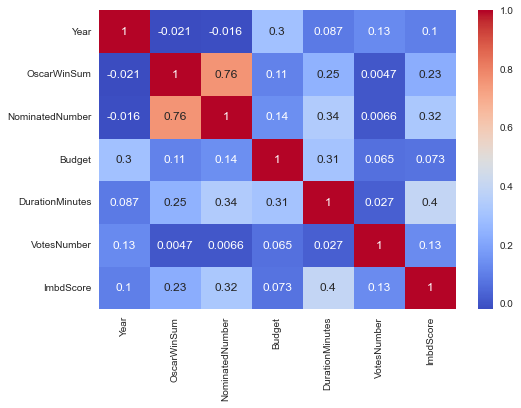

In [9]:
corr = movies[factors].corr()
sb.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sb.color_palette("coolwarm", as_cmap=True))



Як бачимо, мультиколінеарними є кількість виграних номінацій у Оскарі та загальна кількість номінацій Оскару. Видалимо кількість номінацій

<AxesSubplot:>

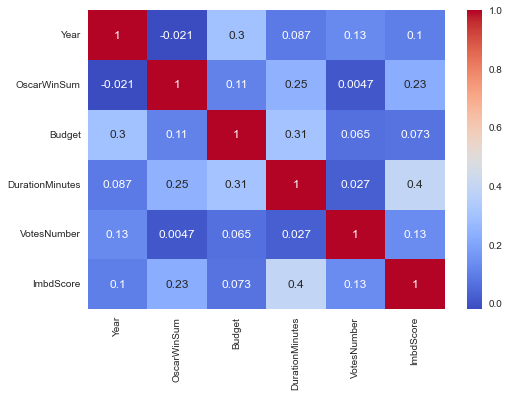

In [10]:
movies.drop(['NominatedNumber'], axis=1, inplace=True)
factors.remove('NominatedNumber')

corr = movies[factors].corr()
sb.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sb.color_palette("coolwarm", as_cmap=True))

Сформуємо набори даних факторів та відгуку

In [11]:
X = movies[factors]
Y = movies[[response]]

Перетворимо жанри у dummy variables:

In [12]:
res = X['Genres'].str.get_dummies(sep='-').add_prefix('genres_')

X = pd.concat([X, res], axis = 1)
X.drop(columns=['Genres'], inplace=True)
X.info()
X.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7374 entries, 2 to 8274
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              7374 non-null   int64  
 1   OscarWinSum       7374 non-null   int64  
 2   Budget            7374 non-null   float64
 3   DurationMinutes   7374 non-null   float64
 4   VotesNumber       7374 non-null   float64
 5   ImbdScore         7374 non-null   float64
 6   RatingName        7374 non-null   object 
 7   genres_Action     7374 non-null   int64  
 8   genres_Adventure  7374 non-null   int64  
 9   genres_Animation  7374 non-null   int64  
 10  genres_Biography  7374 non-null   int64  
 11  genres_Comedy     7374 non-null   int64  
 12  genres_Crime      7374 non-null   int64  
 13  genres_Drama      7374 non-null   int64  
 14  genres_Family     7374 non-null   int64  
 15  genres_Fantasy    7374 non-null   int64  
 16  genres_Fi         7374 non-null   int64  


,Year,OscarWinSum,Budget,DurationMinutes,VotesNumber,ImbdScore,RatingName,genres_Action,genres_Adventure,genres_Animation,...,genres_Mystery,genres_Reality,genres_Romance,genres_Sci,genres_Show,genres_Sport,genres_TV,genres_Thriller,genres_War,genres_Western
2,1987,0,25000000.0,106.0,32000000.0,6.7,PG,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2009,0,5600000.0,85.0,70000000.0,6.5,R,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2016,0,15000000.0,103.0,306304.0,7.2,PG-13,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1999,0,30000000.0,97.0,315247.0,7.3,PG-13,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8,1983,0,4520000.0,101.0,7200000.0,6.3,R,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Аналогічно перетворимо віковий рейтинг:

In [13]:
ageRating = X['RatingName'].str.get_dummies().add_prefix('AgeRating_')

X = pd.concat([X, ageRating], axis = 1)
X.drop(columns=['RatingName'], inplace=True)
X.info()
X.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7374 entries, 2 to 8274
Data columns (total 44 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                7374 non-null   int64  
 1   OscarWinSum         7374 non-null   int64  
 2   Budget              7374 non-null   float64
 3   DurationMinutes     7374 non-null   float64
 4   VotesNumber         7374 non-null   float64
 5   ImbdScore           7374 non-null   float64
 6   genres_Action       7374 non-null   int64  
 7   genres_Adventure    7374 non-null   int64  
 8   genres_Animation    7374 non-null   int64  
 9   genres_Biography    7374 non-null   int64  
 10  genres_Comedy       7374 non-null   int64  
 11  genres_Crime        7374 non-null   int64  
 12  genres_Drama        7374 non-null   int64  
 13  genres_Family       7374 non-null   int64  
 14  genres_Fantasy      7374 non-null   int64  
 15  genres_Fi           7374 non-null   int64  
 16  genres

,Year,OscarWinSum,Budget,DurationMinutes,VotesNumber,ImbdScore,genres_Action,genres_Adventure,genres_Animation,genres_Biography,...,AgeRating_GP,AgeRating_NC-17,AgeRating_PG,AgeRating_PG-13,AgeRating_Passed,AgeRating_R,AgeRating_TV-14,AgeRating_TV-MA,AgeRating_TV-PG,AgeRating_X
2,1987,0,25000000.0,106.0,32000000.0,6.7,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,2009,0,5600000.0,85.0,70000000.0,6.5,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6,2016,0,15000000.0,103.0,306304.0,7.2,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7,1999,0,30000000.0,97.0,315247.0,7.3,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8,1983,0,4520000.0,101.0,7200000.0,6.3,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Розділимо дані на навчальні та тестові, 30% буде віднесено до тестової вибірки

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 5)

In [15]:
def get_scaled_datasets():
    sc_x = StandardScaler()
    sc_y = StandardScaler()
    X_std = sc_x.fit_transform(X)
    y_std = sc_y.fit_transform(Y)
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_std, y_std, test_size=0.3, random_state=5)
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled


X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = get_scaled_datasets()

In [16]:
def model_stats_r2(model, y_test_param, x_test_param):
    y_predicted = model.predict(x_test_param)
    r2 = r2_score(y_test_param, y_predicted)
    return r2

Створимо модель лінійної регресії:

[0.56448927 0.59154234 0.60638816 0.60650003 0.62345455 0.62336575
 0.62349516 0.62312699]


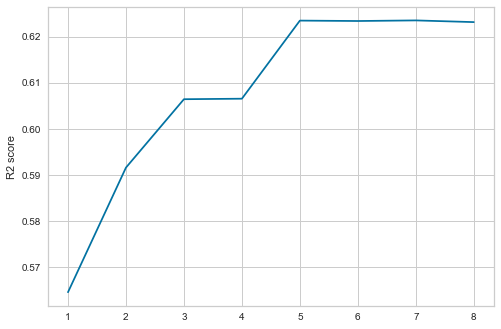

In [34]:
def linear_regr_with_factors(factors_param):
    LinReg = LinearRegression().fit(X_train[factors_param], Y_train)
    return model_stats_r2(LinReg, Y_test, X_test[factors_param])

r2_scores = []

# all factors
factors = np.array(X_train.columns)

r2_scores.append(linear_regr_with_factors(factors))

# we remove age rating
filtered_age = filter(lambda genre: not genre.startswith('AgeRating_'), factors)
factors = np.array(list(filtered_age))
r2_scores.append(linear_regr_with_factors(factors))

# we remove VotesNumber
factors = factors[factors != 'VotesNumber']
r2_scores.append(linear_regr_with_factors(factors))

# we remove DurationMinutes
factors = factors[factors != 'DurationMinutes']
r2_scores.append(linear_regr_with_factors(factors))

# we remove OscarWinSum
factors = factors[factors != 'OscarWinSum']
r2_scores.append(linear_regr_with_factors(factors))

# we remove Year
factors = factors[factors != 'Year']
r2_scores.append(linear_regr_with_factors(factors))

# we remove ImbdScore
factors = factors[factors != 'ImbdScore']
r2_scores.append(linear_regr_with_factors(factors))

# we remove genres
filtered_genres = filter(lambda genre: not genre.startswith('genres_'), factors)
factors = np.array(list(filtered_genres))
r2_scores.append(linear_regr_with_factors(factors))

r2_scores = np.flip(r2_scores)
print(r2_scores)

plt.plot([1, 2, 3, 4, 5, 6, 7, 8], r2_scores)
plt.ylabel('R2 score')
plt.show()


LinReg = LinearRegression().fit(X_train, Y_train)

Створимо модель поліноміальної регресії степеня 2:

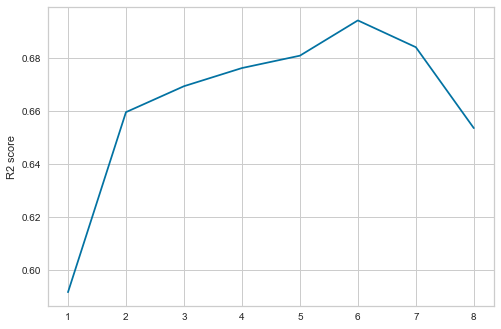

In [39]:
def polynomial_regr_with_factors(factors_param):
    PolReg2 = make_pipeline(PolynomialFeatures(degree=2), LinearRegression()).fit(X_train[factors_param], Y_train)
    return model_stats_r2(PolReg2, Y_test, X_test[factors_param])

# all factors
factors_pol = np.array(X_train.columns).astype(object)

only_genres = np.array(list(filter(lambda genre: genre.startswith('genres_'), factors_pol)))
only_ageRating = np.array(list(filter(lambda genre: genre.startswith('AgeRating_'), factors_pol)))
r2_scores_pol = [
    polynomial_regr_with_factors(['Budget']),
    polynomial_regr_with_factors(['Budget', 'ImbdScore']),
    polynomial_regr_with_factors(np.append(only_genres, ['ImbdScore', 'Budget'])),
    polynomial_regr_with_factors(np.append(only_ageRating, np.append(only_genres, ['ImbdScore', 'Budget']))),
    polynomial_regr_with_factors(np.append(only_ageRating, np.append(only_genres, ['ImbdScore', 'Budget', 'OscarWinSum']))),
    polynomial_regr_with_factors(np.append(only_ageRating, np.append(only_genres, ['ImbdScore', 'Budget', 'OscarWinSum', 'Year']))),
    polynomial_regr_with_factors(np.append(only_ageRating, np.append(only_genres, ['ImbdScore', 'Budget', 'OscarWinSum', 'Year', 'VotesNumber']))),
    polynomial_regr_with_factors(np.append(only_ageRating, np.append(only_genres, ['ImbdScore', 'Budget', 'OscarWinSum', 'Year', 'VotesNumber', 'DurationMinutes']))),
]

plt.plot([1, 2, 3, 4, 5, 6, 7, 8], r2_scores_pol)
plt.ylabel('R2 score')
plt.show()

pol_optimal_factors = np.append(only_ageRating, np.append(only_genres, ['ImbdScore', 'Budget', 'OscarWinSum', 'Year']))
PolReg2 = make_pipeline(PolynomialFeatures(degree=2), LinearRegression()).fit(X_train[pol_optimal_factors], Y_train)

In [19]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train_scaled)

Lasso(alpha=0.1)

In [20]:
rf = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 100, random_state = 18)
rf = rf.fit(X_train, np.array(Y_train))

<ipython-input-20-dd5e7748ba88>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = rf.fit(X_train, np.array(Y_train))


In [21]:
knn_model = KNeighborsRegressor(n_neighbors=14)
knn_model.fit(X_train_scaled, y_train_scaled)

KNeighborsRegressor(n_neighbors=14)

In [40]:
def model_stats(model, name, y_test_param, x_test_param):
    y_predicted = np.array(model.predict(x_test_param))
    y_test_param = np.array(y_test_param)

    r2 = r2_score(y_test_param, y_predicted)
    print(name)
    print('R2: ', r2)
    print('RSE: ', sqrt((np.sum(np.square(y_test_param - y_predicted)))/(len(y_test_param) - 2)))

    mse = (np.square(y_test_param - y_predicted)).mean()
    print('MSE: ', mse)
    print('RMSE: ', np.sqrt(mse))
    print()
    return r2

model_stats(LinReg, 'Linear regression', Y_test, X_test)
model_stats(PolReg2, 'Polynomial regression degree 2', Y_test, X_test[pol_optimal_factors])
model_stats(lasso, 'Lasso', y_test_scaled, X_test_scaled)
model_stats(rf, 'Random forest regressor', Y_test, X_test)
model_stats(knn_model, 'KNeighborsRegressor', y_test_scaled, X_test_scaled)

Linear regression
R2:  0.6231269931728914
RSE:  95931458.17399617
MSE:  9194527591322852.0
RMSE:  95888099.32062921

Polynomial regression degree 2
R2:  0.6943674750943675
RSE:  86389968.20806359
MSE:  7456481711728611.0
RMSE:  86350921.89275463

Lasso
R2:  0.5966879993921164
RSE:  52.707339287515175
MSE:  1.2542037678301943
RMSE:  1.1199123929264263

Random forest regressor
R2:  0.7470950336524754
RSE:  9564521892.469536
MSE:  4.130022768117139e+16
RMSE:  203224574.5011449

KNeighborsRegressor
R2:  0.5769623229825686
RSE:  0.5967541313833966
MSE:  0.3557936537449116
RMSE:  0.5964844119882025



0.5769623229825686

Show plots with fixed params and one changing:

In [41]:
columnsDisplay = ['Year', 'OscarWinSum', 'Budget', 'DurationMinutes', 'VotesNumber', 'ImbdScore'] # 'NominatedNumber', 'Gross'
columnsDisplayPol = ['ImbdScore', 'Budget', 'OscarWinSum', 'Year']
fixedValue = X.iloc[0]

fixed_df = X.copy(deep = True)
for column in X.columns:
    fixed_df[column] = fixedValue[column]

print(fixed_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7374 entries, 2 to 8274
Data columns (total 44 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                7374 non-null   float64
 1   OscarWinSum         7374 non-null   float64
 2   Budget              7374 non-null   float64
 3   DurationMinutes     7374 non-null   float64
 4   VotesNumber         7374 non-null   float64
 5   ImbdScore           7374 non-null   float64
 6   genres_Action       7374 non-null   float64
 7   genres_Adventure    7374 non-null   float64
 8   genres_Animation    7374 non-null   float64
 9   genres_Biography    7374 non-null   float64
 10  genres_Comedy       7374 non-null   float64
 11  genres_Crime        7374 non-null   float64
 12  genres_Drama        7374 non-null   float64
 13  genres_Family       7374 non-null   float64
 14  genres_Fantasy      7374 non-null   float64
 15  genres_Fi           7374 non-null   float64
 16  genres

In [42]:
def show_plots_with_fixed_params(columns_display, model_param, fixed_df_param):
    fig, axs = plt.subplots(1, len(columns_display), figsize=(25,4))
    fig.suptitle(type(model_param).__name__)
    i = 0
    for column_local in columns_display:
        fixed_with_column_param = fixed_df_param.copy(deep = True)
        fixed_with_column_param[column_local] = X[column_local]

        predictions = model_param.predict(fixed_with_column_param)
        axs[i].set_xlabel(column_local)
        axs[i].set_ylabel(response)
        sb.scatterplot(ax=axs[i], x=fixed_with_column_param[column_local].tolist(), y=predictions.flatten().tolist())
        i += 1

In [43]:
def show_plots_with_fixed_params_scaled(columns_display, model_param):
    fig, axs = plt.subplots(1, len(columns_display), figsize=(25,4))
    fig.suptitle(type(model_param).__name__)
    i = 0
    for column_local in columns_display:
        fixed_with_column_param = fixed_df.copy(deep = True)
        fixed_with_column_param[column_local] = X[column_local]

        sc = StandardScaler()
        fixed_with_column_param = sc.fit_transform(fixed_with_column_param)

        predictions = model_param.predict(fixed_with_column_param)

        axs[i].set_xlabel(column_local)
        axs[i].set_ylabel(response)
        sb.scatterplot(ax=axs[i], x=fixed_with_column_param[:, i].tolist(), y=predictions.flatten().tolist())
        i += 1

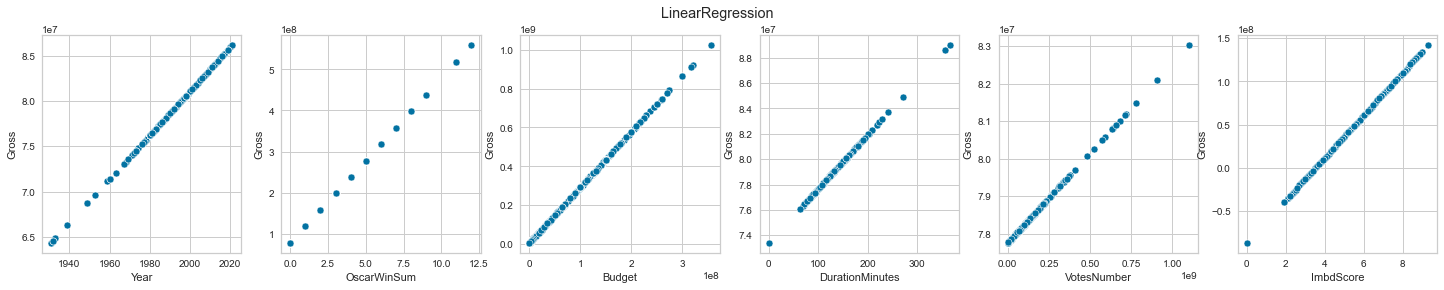

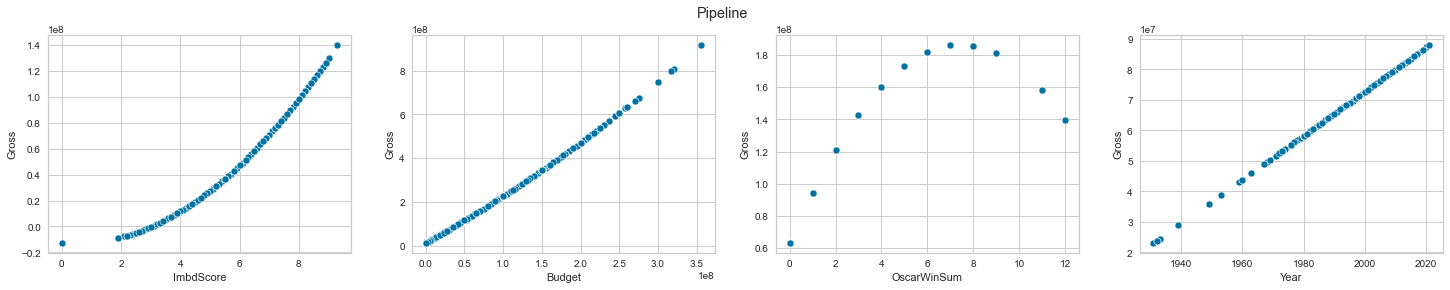

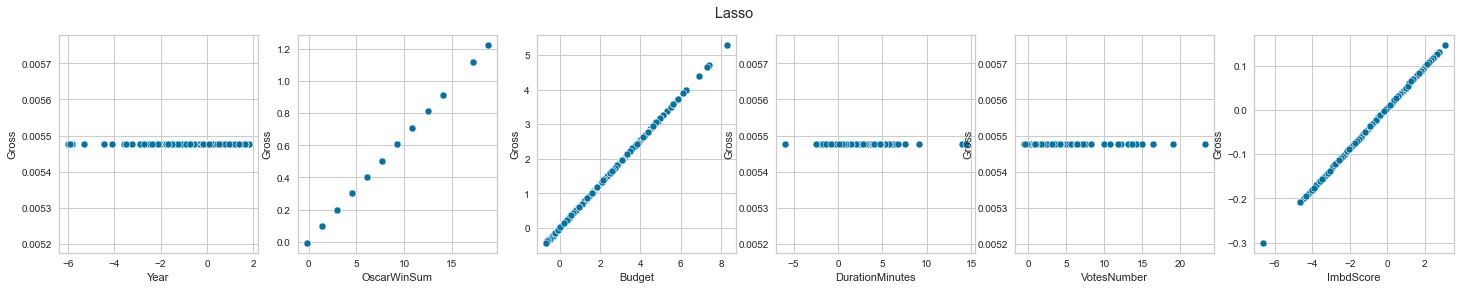

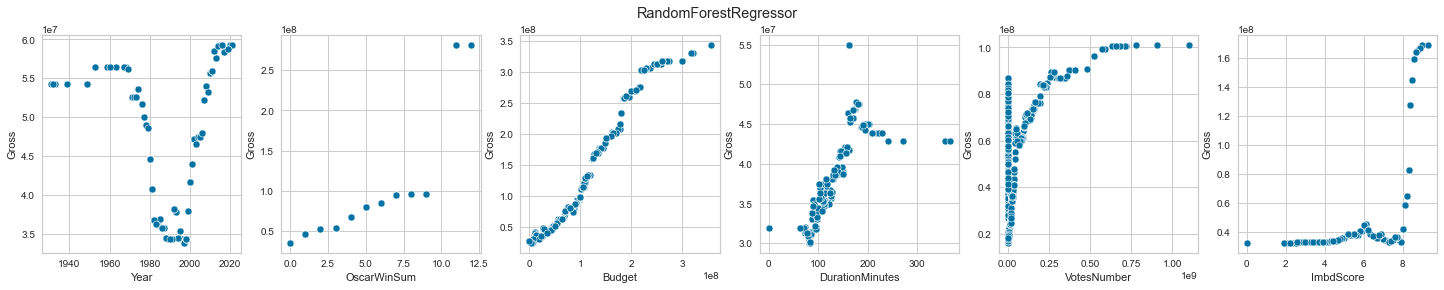

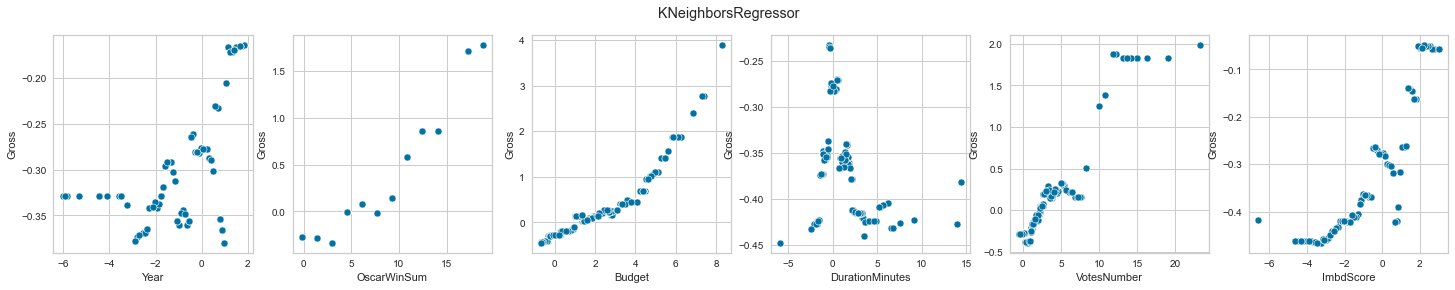

In [44]:
show_plots_with_fixed_params(columnsDisplay, LinReg, fixed_df)
show_plots_with_fixed_params(columnsDisplayPol, PolReg2, fixed_df[pol_optimal_factors])
show_plots_with_fixed_params_scaled(columnsDisplay, lasso)
show_plots_with_fixed_params(columnsDisplay, rf, fixed_df)
show_plots_with_fixed_params_scaled(columnsDisplay, knn_model)

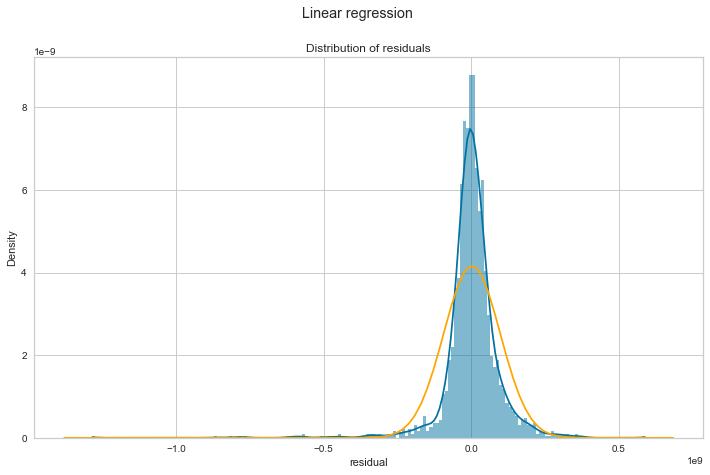

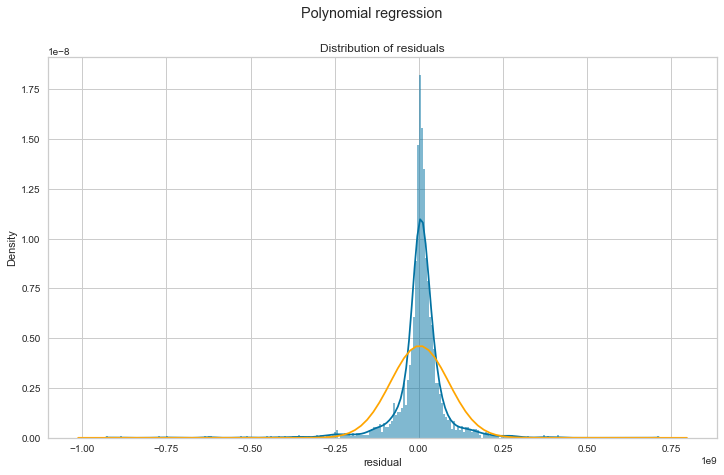

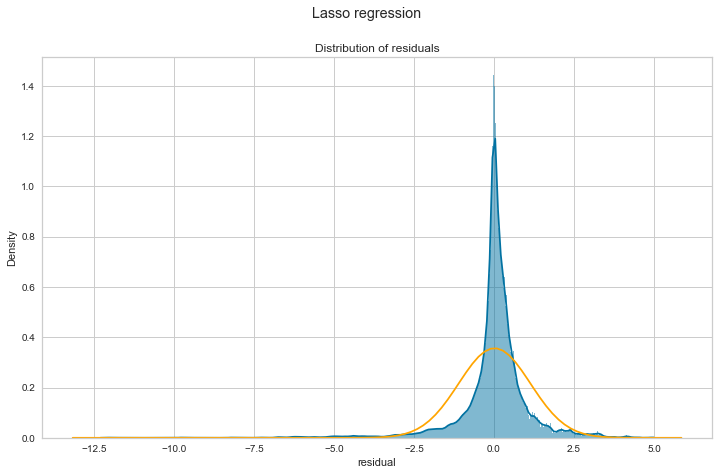

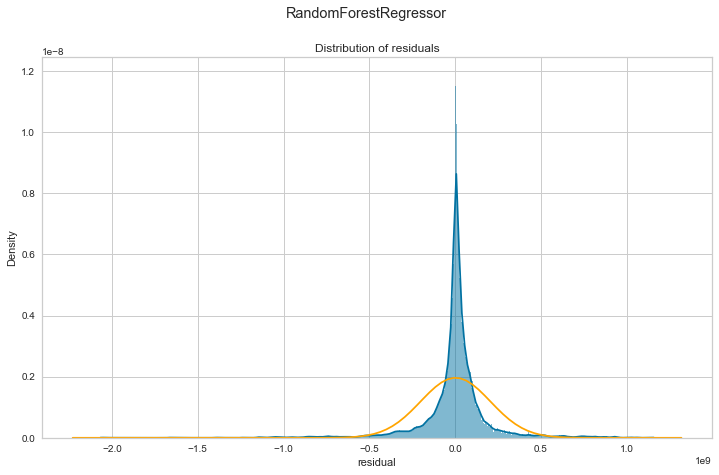

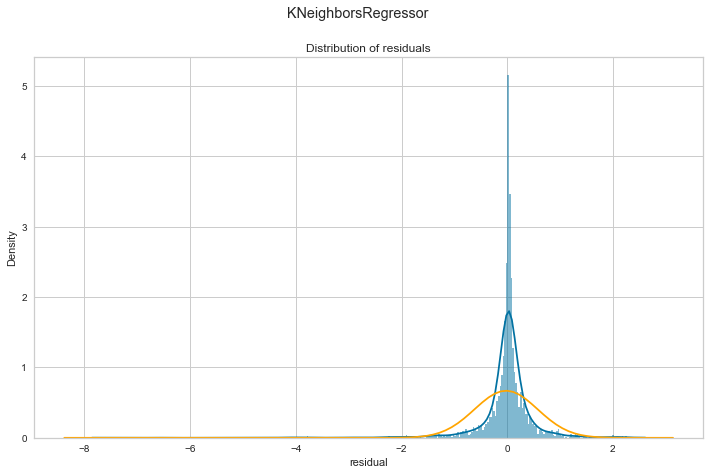

In [46]:
def show_residuals_plot(y_actual, y_predicted, title):
    resid = np.array(y_predicted) - np.array(y_actual)
    resid = resid.flatten().tolist()

    fig, ax = plt.subplots(figsize = (12, 7))
    fig.suptitle(title)
    sb.histplot(x=resid, ax=ax, stat="density", linewidth=0, kde=True)
    ax.set(title="Distribution of residuals", xlabel="residual")

    # # plot corresponding normal curve

    mu, std = stats.norm.fit(resid)

    xmin, xmax = plt.xlim() # the maximum x values from the histogram above
    x = np.linspace(xmin, xmax, 100) # generate some x values
    p = stats.norm.pdf(x, mu, std) # calculate the y values for the normal curve
    sb.lineplot(x=x, y=p, color="orange", ax=ax)
    plt.show()

show_residuals_plot(Y_test, LinReg.predict(X_test), 'Linear regression')
show_residuals_plot(Y_test, PolReg2.predict(X_test[pol_optimal_factors]), 'Polynomial regression')
show_residuals_plot(y_test_scaled, lasso.predict(X_test_scaled), 'Lasso regression')
show_residuals_plot(Y_test, rf.predict(X_test), 'RandomForestRegressor')
show_residuals_plot(y_test_scaled, knn_model.predict(X_test_scaled), 'KNeighborsRegressor')

In [48]:
from scipy.stats import normaltest

def residuals_normality(y_actual, y_predicted, title):
    resid = np.array(y_predicted) - np.array(y_actual)
    resid = resid.flatten().tolist()

    stat, p = normaltest(resid)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print(title + ' residuals look Normal')
    else:
        print(title + ' residuals dont look Normal')

residuals_normality(Y_test, LinReg.predict(X_test), 'Linear regression')
residuals_normality(Y_test, PolReg2.predict(X_test[pol_optimal_factors]), 'Polynomial regression')
residuals_normality(y_test_scaled, lasso.predict(X_test_scaled), 'Lasso regression')
residuals_normality(Y_test, rf.predict(X_test), 'RandomForestRegressor')
residuals_normality(y_test_scaled, knn_model.predict(X_test_scaled), 'KNeighborsRegressor')

Statistics=1573.634, p=0.000
Linear regression residuals dont look Normal
Statistics=1436.031, p=0.000
Polynomial regression residuals dont look Normal
Statistics=2578311.727, p=0.000
Lasso regression residuals dont look Normal
Statistics=1724529.174, p=0.000
RandomForestRegressor residuals dont look Normal
Statistics=1917.126, p=0.000
KNeighborsRegressor residuals dont look Normal


c:\users\acer\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\users\acer\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


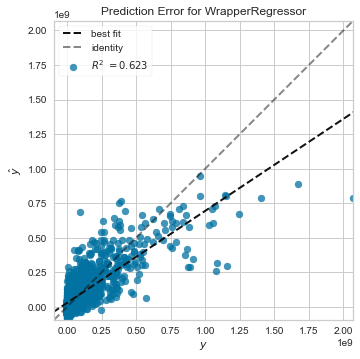

<AxesSubplot:title={'center':'Prediction Error for WrapperRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [49]:
from sklearn.base import BaseEstimator, RegressorMixin
class WrapperRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        return self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X).flatten()

visualizer = PredictionError(WrapperRegressor(LinReg))
visualizer.score(X_test.to_numpy(), Y_test.to_numpy())
visualizer.show()

c:\users\acer\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\users\acer\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


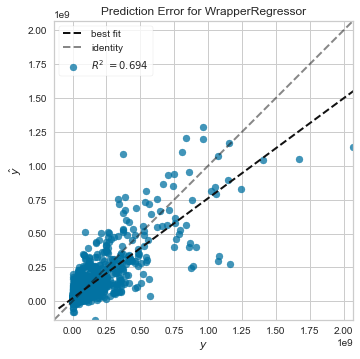

<AxesSubplot:title={'center':'Prediction Error for WrapperRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [50]:
visualizer = PredictionError(WrapperRegressor(PolReg2))
visualizer.score(X_test[pol_optimal_factors].to_numpy(), Y_test.to_numpy())
visualizer.show()

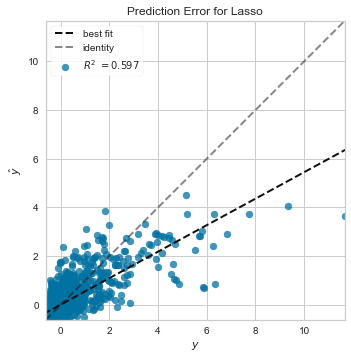

<AxesSubplot:title={'center':'Prediction Error for Lasso'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [51]:
visualizer = PredictionError(lasso)
visualizer.score(X_test_scaled, y_test_scaled)
visualizer.show()

c:\users\acer\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\users\acer\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


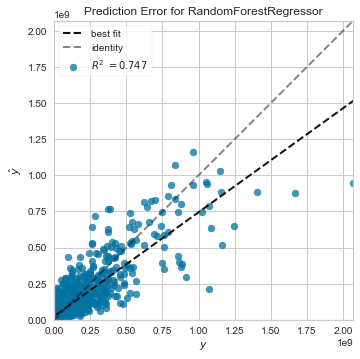

<AxesSubplot:title={'center':'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [52]:
visualizer = PredictionError(rf)
visualizer.score(X_test.to_numpy(), Y_test.to_numpy())
visualizer.show()

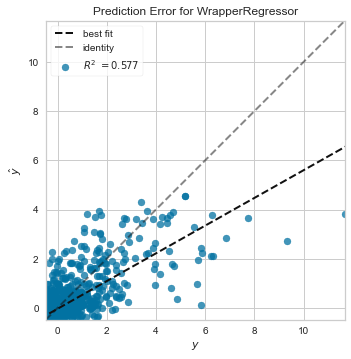

<AxesSubplot:title={'center':'Prediction Error for WrapperRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [53]:
visualizer = PredictionError(WrapperRegressor(knn_model))
visualizer.score(X_test_scaled, y_test_scaled)
visualizer.show()